<a href="https://colab.research.google.com/github/hyesungKomet/AimAtCoin/blob/main/BORA_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyupbit

     |████████████████████████████████| 103 kB 33.6 MB/s 


In [2]:
import pyupbit

In [44]:
coin = "KRW-BORA"
#BTC 최근 200시간의 데이터 불러옴
df = pyupbit.get_ohlcv(coin, interval="minute60", count = 500)
df

,open,high,low,close,volume,value
2021-12-17 05:00:00,1170.0,1225.0,1170.0,1205.0,3.598757e+06,4.326470e+09
2021-12-17 06:00:00,1200.0,1235.0,1200.0,1225.0,6.376454e+06,7.794342e+09
2021-12-17 07:00:00,1225.0,1230.0,1185.0,1190.0,6.913615e+06,8.304087e+09
2021-12-17 08:00:00,1190.0,1215.0,1175.0,1210.0,1.010946e+07,1.205250e+10
2021-12-17 09:00:00,1205.0,1230.0,1180.0,1200.0,2.207131e+07,2.657499e+10
...,...,...,...,...,...,...
2022-01-06 22:00:00,1135.0,1175.0,1135.0,1160.0,5.135353e+06,5.921636e+09
2022-01-06 23:00:00,1160.0,1200.0,1160.0,1170.0,1.378059e+07,1.619375e+10
2022-01-07 00:00:00,1170.0,1175.0,1150.0,1170.0,5.598524e+06,6.502879e+09
2022-01-07 01:00:00,1170.0,1180.0,1155.0,1165.0,1.569244e+06,1.832556e+09


In [45]:
#시간(ds)와 종가(y)값만 남김
df = df.reset_index() #index 지움
df['ds'] = df['index'] #ds로 index 변경
df['y'] = df['close']
data = df[['ds','y']] #data는 종가와 시간으로 구성됨!
data

,ds,y
0,2021-12-17 05:00:00,1205.0
1,2021-12-17 06:00:00,1225.0
2,2021-12-17 07:00:00,1190.0
3,2021-12-17 08:00:00,1210.0
4,2021-12-17 09:00:00,1200.0
...,...,...
495,2022-01-06 22:00:00,1160.0
496,2022-01-06 23:00:00,1170.0
497,2022-01-07 00:00:00,1170.0
498,2022-01-07 01:00:00,1165.0


In [46]:
#prophet 불러옴
from fbprophet import Prophet

In [47]:
#학습
model = Prophet()
model.fit(data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [48]:
#24시간 미래 예측
future = model.make_future_dataframe(periods=24, freq='H')
forecast = model.predict(future)

* 1시간, 30분, 10분, 2시간 으로 끊어봤는데 각각 전혀 다른 예측이 나온다. 표본이 너무 적다... 며칠 전까지 혹은 몇달 전까지의 데이터만으로는 차트에서의 경향성 등을 풍부하게 반영하지 못한다...
* 그나마 1시간으로 디폴트 200보다 큰 500개의 데이터로 돌렸을 때 좀 차트 예측이 잘 나오는 듯... 그전까지는 직전에 내려가면 쭉 내려가도록, 직전에 올라가면 쭉 올라가도록만 표현됐는데 이 경우는 반등을 예측하기도 한다.

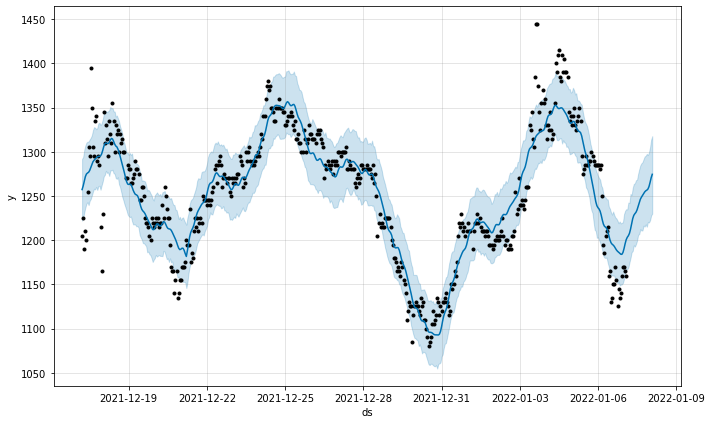

In [50]:
#그래프1
fig1 = model.plot(forecast)

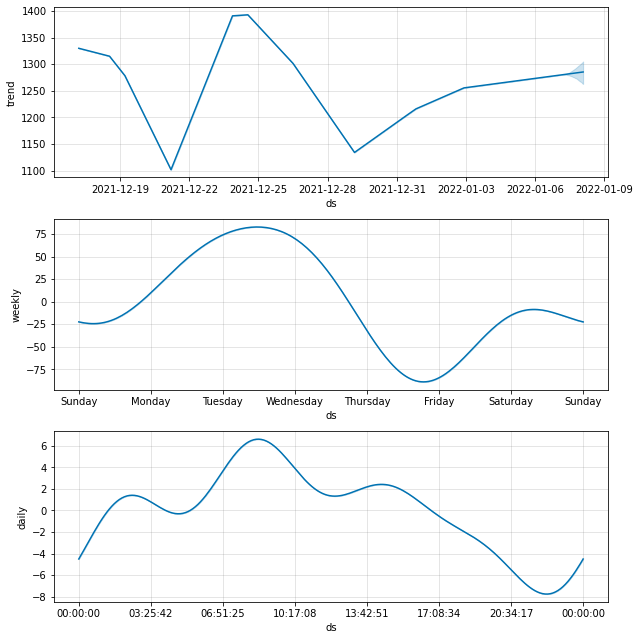

In [52]:
#그래프2 #오전 9시부근에서 가격이 높게 책정되는건 9시경주마 뭐시기 그거 반영인 것으로 보인다
fig2 = model.plot_components(forecast)

In [53]:
#매수 시점의 가격
nowValue = pyupbit.get_current_price("KRW-BORA")
nowValue

1170.0

In [54]:
#종가의 가격을 구함

#현재 시간이 자정 이전
closeDf = forecast[forecast['ds'] == forecast.iloc[-1]['ds'].replace(hour=9)]

#현재 시간이 자정 이후
if len(closeDf) == 0:
  closeDf = forecast[forecast['ds'] == data.iloc[-1]['ds'].replace(hour=9)]

#어쨋든 당일 종가
closeValue = closeDf['yhat'].values[0]
closeValue

1228.118432065233

In [55]:
#구체적인 가격
print("현재 시점 가격: ", nowValue)
print("종가의 가격: ", closeValue)

현재 시점 가격:  1170.0
종가의 가격:  1228.118432065233


In [56]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-17 05:00:00,1329.984967,1222.135093,1292.033923,1329.984967,1329.984967,-72.688843,-72.688843,-72.688843,-0.244172,-0.244172,-0.244172,-72.444672,-72.444672,-72.444672,0.0,0.0,0.0,1257.296124
1,2021-12-17 06:00:00,1329.519539,1224.686093,1294.050526,1329.519539,1329.519539,-68.166295,-68.166295,-68.166295,1.279258,1.279258,1.279258,-69.445553,-69.445553,-69.445553,0.0,0.0,0.0,1261.353243
2,2021-12-17 07:00:00,1329.054110,1231.512713,1302.043488,1329.054110,1329.054110,-62.210492,-62.210492,-62.210492,4.081946,4.081946,4.081946,-66.292438,-66.292438,-66.292438,0.0,0.0,0.0,1266.843618
3,2021-12-17 08:00:00,1328.588682,1236.886309,1307.117108,1328.588682,1328.588682,-56.738097,-56.738097,-56.738097,6.274672,6.274672,6.274672,-63.012769,-63.012769,-63.012769,0.0,0.0,0.0,1271.850585
4,2021-12-17 09:00:00,1328.123254,1241.287090,1310.345723,1328.123254,1328.123254,-53.260631,-53.260631,-53.260631,6.373943,6.373943,6.373943,-59.634575,-59.634575,-59.634575,0.0,0.0,0.0,1274.862622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,2022-01-07 22:00:00,1284.509875,1220.678640,1296.224389,1268.789228,1298.442427,-26.688206,-26.688206,-26.688206,-7.692191,-7.692191,-7.692191,-18.996015,-18.996015,-18.996015,0.0,0.0,0.0,1257.821669
520,2022-01-07 23:00:00,1284.750706,1219.993536,1299.382517,1267.454689,1300.026763,-24.054413,-24.054413,-24.054413,-7.142235,-7.142235,-7.142235,-16.912178,-16.912178,-16.912178,0.0,0.0,0.0,1260.696294
521,2022-01-08 00:00:00,1284.991538,1222.609966,1305.392707,1266.611992,1301.561121,-19.561916,-19.561916,-19.561916,-4.507084,-4.507084,-4.507084,-15.054832,-15.054832,-15.054832,0.0,0.0,0.0,1265.429622
522,2022-01-08 01:00:00,1285.232370,1228.104381,1313.859333,1264.345285,1303.347014,-14.545163,-14.545163,-14.545163,-1.114702,-1.114702,-1.114702,-13.430461,-13.430461,-13.430461,0.0,0.0,0.0,1270.687207
